# Machine learning for flux samples from RNA-seq contextualized Cd models

In [3]:
# Load libraries
import pandas as pd
import numpy as np
import cobra

In [4]:
# Load models
cd630=cobra.io.read_sbml_model("models/iCdG709.sbml")
r20291=cobra.io.read_sbml_model("models/iCdR703.sbml")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-04-21


https://identifiers.org/seed.reaction/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id


In [205]:
# Load flux sampling data
fsdf = pd.read_csv('../data/rnaseqFluxSampling.csv').drop('Unnamed: 0', axis=1)
#fsdf = fsdf.sort_values(by=['toxin2','strain','condition'], ascending = False)
fsdf.head()

,rxn03408_c,rxn01358_c,rxn00258_c,rxn01218_c,rxn01547_c,rxn00001_c,rxn01297_c,rxn00337_c,rxn12512_c,rxn08669_c,...,rxn01368_c,rxn02988_c,rxn02402_c,EX_cpd29699_e,rxn30270_c,rxn30242_c,EX_cpd29690_e,rxn30276_c,rxn30245_c,toxin2
1300,33.021642,0.000000,0.000000,-3.467272,NaN,629.575285,0.000000,86.164470,NaN,-0.027518,...,NaN,0.440289,0.440289,-10.919156,10.919156,10.919156,-14.177291,14.177291,14.177291,low
1301,32.839005,1000.000000,296.298764,-3.448096,NaN,626.473472,0.000000,85.687912,NaN,-0.027366,...,NaN,0.000000,0.000000,-10.858764,10.858764,10.858764,-14.098880,14.098880,14.098880,low
1302,32.839005,221.347385,955.926809,-3.448096,NaN,626.473472,-842.706318,85.687912,NaN,-0.027366,...,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,-14.098880,14.098880,14.098880,low
1303,32.839005,807.546050,997.657484,-3.448096,NaN,591.784307,-931.105474,85.687912,NaN,-0.027366,...,NaN,0.437853,0.437853,0.000000,0.000000,0.000000,-14.098880,14.098880,14.098880,low
1304,32.839005,1000.000000,139.992358,-3.448096,NaN,626.473472,-5.426222,85.687912,NaN,-0.027366,...,NaN,0.000000,0.000000,-10.858764,10.858764,10.858764,-14.098880,14.098880,14.098880,low


# Feature selection

## 1. Normalize data

In [4]:
fsdf1 = fsdf.drop(columns=['condition','strain','toxin','toxin2'])

In [5]:
# Normalize flux sampling data
fsdf1 = fsdf1/1000

# Fill NaN rxns
fsdf1 = fsdf1.fillna(0)

# Drop reactions that don't carry flux in all conditions (dropped 0 rxns)
fsdf1 = fsdf1.loc[~(fsdf1==0).all(axis=1)]

In [6]:
fsdf1.head()

,rxn03408_c,rxn01358_c,rxn00258_c,rxn01218_c,rxn01547_c,rxn00001_c,rxn01297_c,rxn00337_c,rxn12512_c,rxn08669_c,...,rxn01366_c,rxn01368_c,rxn02988_c,rxn02402_c,EX_cpd29699_e,rxn30270_c,rxn30242_c,EX_cpd29690_e,rxn30276_c,rxn30245_c
0,0.029595,0.000000,-0.001924,-0.003107,0.187382,0.514632,-0.187382,0.077224,0.000109,-0.000025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.031015,1.000000,-0.002016,-0.003257,0.000000,0.539329,0.000000,0.080930,0.000114,-0.000026,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.033982,1.000000,-0.002209,-0.003568,0.000000,0.590911,0.000000,0.088670,0.000125,-0.000028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.029595,0.298943,-0.001924,-0.003107,0.166434,0.514632,-0.166434,0.077224,0.000109,-0.000025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.029614,1.000000,-0.001925,-0.003109,0.000000,0.294548,0.000000,0.077273,0.000109,-0.000025,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Check low variability 
- Check features w/low variability across all conditions/samples

Text(0, 0.5, 'Frequency')

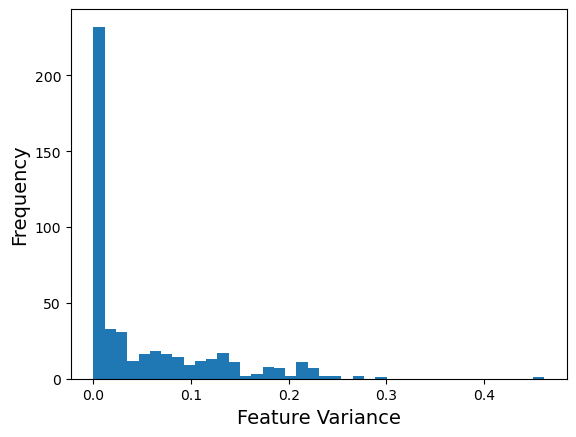

In [7]:
var_hist = fsdf1.var().plot.hist(bins=40)
var_hist.set_xlabel('Feature Variance', fontsize=14)
var_hist.set_ylabel('Frequency', fontsize=14)
#plt.savefig('../figures/fs_NZV.jpeg',bbox_inches='tight', dpi = 600)

In [8]:
fsdf1.var().shape

(482,)

In [9]:
nzvFeatures = fsdf1.var()[fsdf1.var() < 0.005].index # 224 features with variance < 0.005 (near zero variance - NZV)

In [10]:
len(nzvFeatures)

224

In [11]:
# Remove features with low variance (< 0.005)
fsdf2 = fsdf1.drop(columns = nzvFeatures)

## 3. Check high correlation

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

In [13]:
# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [14]:
corrdf = fsdf2.corr(method='pearson')

In [15]:
# Pairs of both positively and negatively correlated features
corrFeaturesAll = set()
for i in range(len(corrdf .columns)):
    for j in range(i):
        if abs(corrdf.iloc[i, j]) > 0.8:
            colname = corrdf.columns[i]
            corrFeaturesAll.add(colname)

In [16]:
# Pairs of only positively correlated features
corrFeaturesPos = set()
for i in range(len(corrdf .columns)):
    for j in range(i):
        if corrdf.iloc[i, j] > 0.8:
            colname = corrdf.columns[i]
            corrFeaturesPos.add(colname)

In [17]:
print(len(corrFeaturesAll)) # 61.2% of remaining features positively or negatively correlated (359 rxns in pre-NZV filter)
print(len(corrFeaturesPos)) # 36.8% of remaining features positively correlated (274 rxns in pre-NZV filter)

158
95


In [18]:
mask = np.triu(np.ones_like(corrdf))

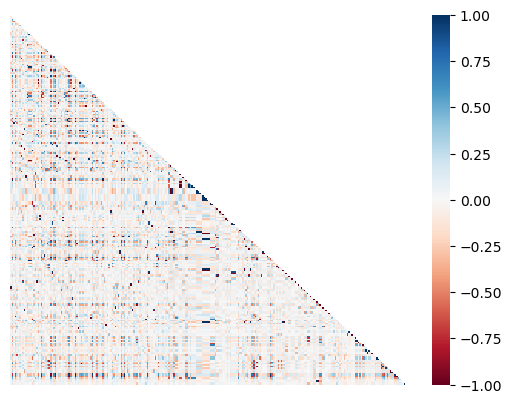

In [19]:
# plotting a triangle correlation heatmap
ax = sns.heatmap(corrdf,
                 cmap='RdBu',
                 #cmap=plt.cm.get_cmap('Blues', 2),
                 #norm=MidpointNormalize(midpoint = 0.8, vmin = -1, vmax = 1),
                 #cbar_kws={"ticks": np.arange(-1,1.1, 1.8)},
                 annot=False,
                 mask=mask) 
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(left=False, bottom=False)

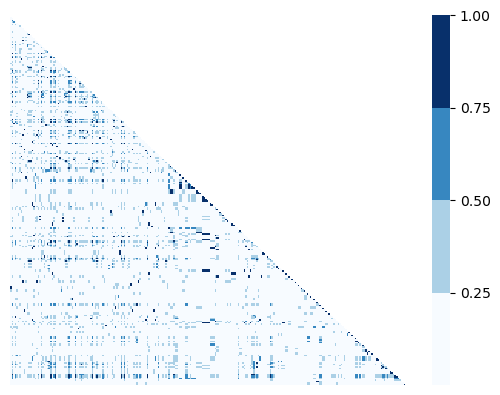

In [20]:
# plotting a triangle correlation heatmap (Absolute value)
ax = sns.heatmap(np.abs(corrdf), 
                 cmap=plt.cm.get_cmap('Blues', 4),
                 cbar_kws={"ticks": np.arange(0,1.1, 0.25)},
                 annot=False, 
                 mask=mask) #plt.cm.get_cmap('Blues', 4)
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(left=False, bottom=False)
#plt.savefig('../figures/fs_absPearsonCorr1.jpeg',bbox_inches='tight', dpi = 600)

/var/folders/85/n42jk96d3hsbdfcjbr1qlmb80000gp/T/ipykernel_38938/4177127772.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mask1 = np.triu(np.ones_like(corrdf.loc[corrFeaturesPos, corrFeaturesPos]))
/var/folders/85/n42jk96d3hsbdfcjbr1qlmb80000gp/T/ipykernel_38938/4177127772.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ax = sns.heatmap(corrdf.loc[corrFeaturesPos, corrFeaturesPos],


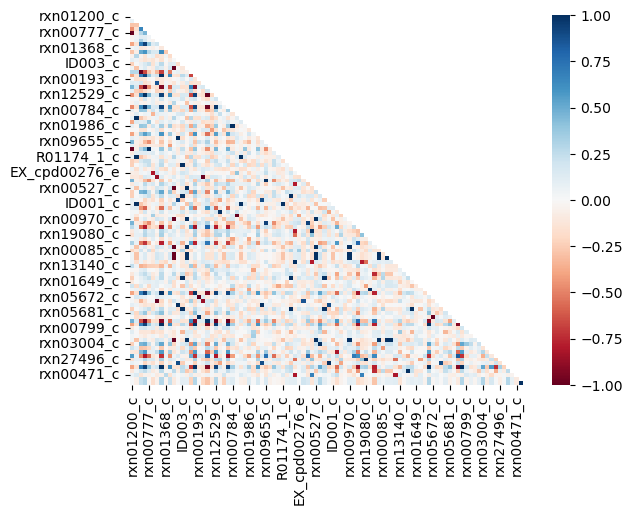

In [21]:
# Features positively correlated w/at least one other feature (Pearson's coefficient > 0.8)
mask1 = np.triu(np.ones_like(corrdf.loc[corrFeaturesPos, corrFeaturesPos]))
ax = sns.heatmap(corrdf.loc[corrFeaturesPos, corrFeaturesPos],
                 cmap='RdBu',
                 #cmap=plt.cm.get_cmap('Blues', 2),
                 #norm=MidpointNormalize(midpoint = 0.8, vmin = -1, vmax = 1),
                 #cbar_kws={"ticks": np.arange(-1,1.1, 1.8)},
                 annot=False,
                 mask=mask1) 

### Remove positively correlated features
- Pearson's coefficient > 0.8

In [22]:
# Remove positively correlated features (Pearson's > 0.8)
fsdf3 = fsdf2.drop(columns=corrFeaturesPos) #163 features remaining (33.8% of total features)

In [23]:
# Remove all highly correlated features (Pearson's > |0.8|)
fsdf4  = fsdf2.drop(columns=corrFeaturesAll) # 100 features remaining (20.7% of total features)

# Machine Learning

## 4. Stratified random cross-validation

Steps:
- Manually split data into test-train? 
    - Random
    - Stratified: equal number of conditions from low/high toxin categories
    - Number of iterations? 5?
    - How to measure success of ea iteration? how to average across? Can still do K-fold cross validation if manually select test-train splits?
        - Leave one out cross validatioin (LOOCV) may be a good choice (16 total conditions is small dataset)
        
Alternatively:
- Try sklearn Group K-Fold or Stratified Group K-Fold

In [322]:
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

### Cross validation test 1
- Cross validation of flux sampling df
- Feature selection filters:
    - NZV < 0.005 
    - Positive Pearson correlation > 0.8

In [25]:
X = fsdf3 # Features
y = fsdf['toxin2'] # Target
G = fsdf['condition'] # Groups (16 RIPTiDe conditions)

#### K-Fold splits

In [26]:
# Set up stratified group K-folds (k=5)
sgkf1 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=23)

In [122]:
fsdf_sorted = fsdf.sort_values(by=['toxin2','strain','condition'], ascending = False)

In [188]:
#cpal=plt.cm.get_cmap('tab20b', 16)
group_map = dict(zip(fsdf_sorted['condition'].unique(), plt.cm.get_cmap('tab20c', 16).colors))
class_map = class_map = {'low':'#b3e0de', 'high':'#006a6a'}
strain_map = {'CD630':'#d2a3d3','CDR20291':'#955a98'}

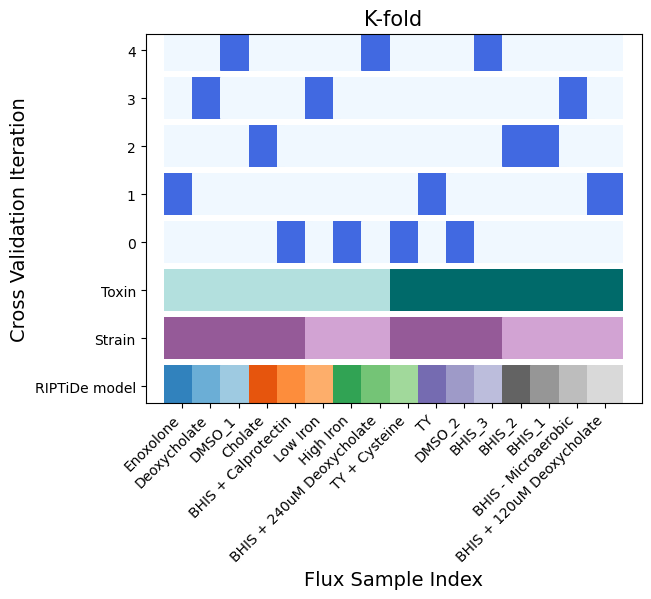

In [231]:
# Visualize K-folds using modified code from sklearn: 
#(https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

f, ax = plt.subplots(1,1)
for ii, (tr, tt) in enumerate(sgkf1.split(X, y, groups=G)):
    # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 3.5] * len(indices),
            c=indices,
            marker="_",
            lw=30,
            cmap=colors.ListedColormap(['aliceblue','royalblue']), #plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )
        
# Conditions (groups)
ax.scatter(range(len(fsdf_sorted['condition'])), [0.5]*len(fsdf_sorted['condition']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['condition'].map(group_map))

# Strains (another class)

ax.scatter(range(len(fsdf_sorted['strain'])), [1.5]*len(fsdf_sorted['strain']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['strain'].map(strain_map))

# Toxins (classes)
ax.scatter(range(len(fsdf_sorted['toxin2'])), [2.5]*len(fsdf_sorted['toxin2']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['toxin2'].map(class_map))

yticklabels = [ "RIPTiDe model", 'Strain', "Toxin"] + list(range(5));
ax.set(yticks=np.arange(8) + 0.5,
      yticklabels=yticklabels,
      xticks=np.arange(50, 1600, step=100),
      );
ax.set_xticklabels(list(fsdf_sorted['condition'].unique()), rotation = 45, ha="right");
ax.set_xlabel('Flux Sample Index', fontsize=14)
ax.set_ylabel('Cross Validation Iteration', fontsize=14)
ax.set_title('K-fold', fontsize=15);

#plt.savefig('../figures/KfoldSplits_sgkf1.jpeg',bbox_inches='tight', dpi = 600)

#### Accuracy

In [235]:
# Create a classifier model
model=RandomForestClassifier(n_estimators=500, random_state=23)

In [245]:
# Run cross validation
cvs1 = cross_val_score(model, X, y, groups=G, scoring="accuracy", cv=sgkf1)

In [295]:
cvs1.mean()

0.5713333333333332

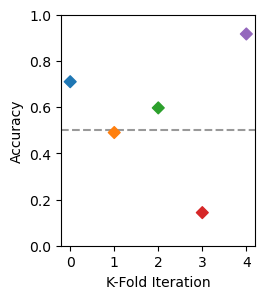

In [294]:
f, ax = plt.subplots(figsize=(2.5,3))
ax.scatter(list(range(5)), cvs1, marker='D', c=['tab:blue','tab:orange','tab:green','tab:red','tab:purple'])
ax.set(xticks=np.arange(5),
      ylim=[0,1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('K-Fold Iteration');
ax.axhline(y = 0.5, color = 'black', linestyle = 'dashed', alpha=0.4, zorder=0)

#plt.savefig('../figures/accuracy_sgkf1.jpeg',bbox_inches='tight', dpi = 600)

#### ROC-AUC curves

/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


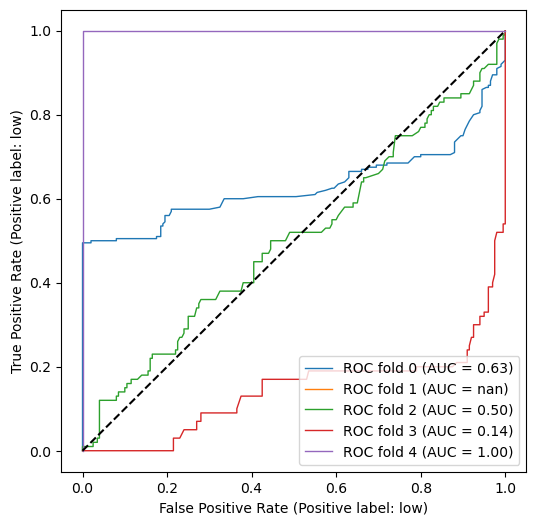

In [270]:
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(sgkf1.split(X, y, groups=G)):
    model.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        #alpha=0.5,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

#plt.savefig('../figures/rocAUC_sgkf1.jpeg',bbox_inches='tight', dpi = 600)

#### Model predictions

In [316]:
# Split data into train (75%) and test (25%) sets (takes the final k-fold for model predictions)
for train, test in StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=25).split(X,y,groups=G):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

In [321]:
# Train model
model.fit(X_train, y_train)

# Predictions
yPred = model.predict(X_test)

In [323]:
# Metrics
print("Accuracy:",metrics.accuracy_score(y_test, yPred))
print("Classification Report:")
print(metrics.classification_report(y_test, yPred))
print("Confusion Matrix:")
conMat = metrics.confusion_matrix(y_test, yPred)
print(conMat)

Accuracy: 0.635
Classification Report:
              precision    recall  f1-score   support

        high       0.61      0.76      0.68       200
         low       0.68      0.51      0.58       200

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.63       400
weighted avg       0.64      0.64      0.63       400

Confusion Matrix:
[[152  48]
 [ 98 102]]


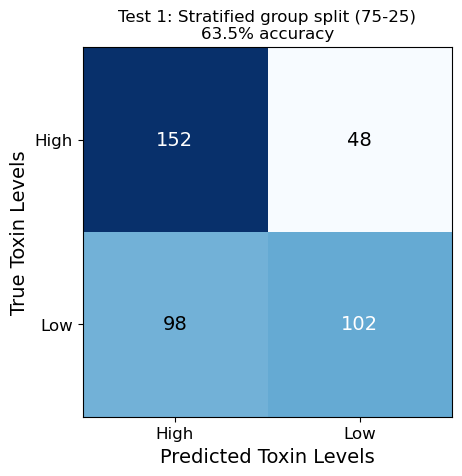

In [356]:
f,ax = plt.subplots(1,1)
ax.imshow(conMat, cmap='Blues')
ax.set_xticks([0,1])
ax.set_xticklabels(['High','Low'], fontsize = 12)
ax.set_xlabel('Predicted Toxin Levels', fontsize=14)
ax.set_yticks([0,1])
ax.set_yticklabels(['High','Low'], fontsize = 12)
ax.set_ylabel('True Toxin Levels', fontsize=14)
for i in range(conMat.shape[0]):
    for j in range(conMat.shape[1]):
        if i == j: c = 'white'
        else: c = 'black'
        ax.text(j, i, "{:.0f}".format(conMat[i,j]), size = 14, ha="center", va="center", color = c)
ax.set_title("Test 1: Stratified group split (75-25)\n63.5% accuracy");

#plt.savefig('../figures/rfConfusionMatrix_sgkf1.jpeg',bbox_inches='tight', dpi = 600)

# TO DO:
## fix so annotations are white on dark colors (https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

In [333]:
# Feature importance:
feature_imp1 = pd.Series(model.feature_importances_,index=X.columns.to_list()).sort_values(ascending=False)
# Select top 20 features
top20_1 = feature_imp1.head(20).sort_values(ascending=True)

In [339]:
# Add reaction names
top20_1 = pd.DataFrame(top20_1)
for i in top20_1.index:
    try:
        top20_1.loc[i, 'name'] = r20291.reactions.get_by_id(i).name
    except KeyError:
        top20_1.loc[i, 'name'] = cd630.reactions.get_by_id(i).name

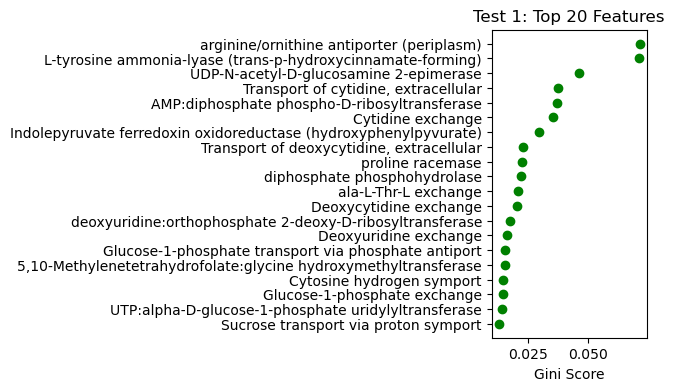

In [354]:
f, ax = plt.subplots(figsize=(2,4))
ax.scatter(top20_1[0], top20_1['name'], c='green')
ax.set_xlabel('Gini Score')
ax.set_title('Test 1: Top 20 Features')
             
#plt.savefig('../figures/top20Predictions_sgkf1.jpeg',bbox_inches='tight', dpi = 600)

In [348]:
top20_1

,0,name
rxn09658_c,0.012589,Sucrose transport via proton symport
rxn00213_c,0.013854,UTP:alpha-D-glucose-1-phosphate uridylyltransf...
EX_cpd00089_e,0.014470,Glucose-1-phosphate exchange
rxn05527_c,0.014488,Cytosine hydrogen symport
rxn00692_c,0.015038,"5,10-Methylenetetrahydrofolate:glycine hydroxy..."
rxn05562_c,0.015127,Glucose-1-phosphate transport via phosphate an...
EX_cpd00412_e,0.015985,Deoxyuridine exchange
rxn01799_c,0.017230,deoxyuridine:orthophosphate 2-deoxy-D-ribosylt...
EX_cpd00654_e,0.020173,Deoxycytidine exchange
EX_cpd11582_e,0.020473,ala-L-Thr-L exchange


### Cross validation test 2
- Feature selection filters: 
    - NZV < 0.005
    - Absolute Pearson's correlation > 0.8

In [370]:
X = fsdf4 # Features
y = fsdf['toxin2'] # Target
G = fsdf['condition'] # Groups (16 RIPTiDe conditions)

In [122]:
fsdf_sorted = fsdf.sort_values(by=['toxin2','strain','condition'], ascending = False)

#### K-Fold splits

In [371]:
# Set up stratified group K-folds (k=5)
sgkf2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=23)

In [188]:
# Set up color maps to visualize K-fold splits
group_map = dict(zip(fsdf_sorted['condition'].unique(), plt.cm.get_cmap('tab20c', 16).colors))
class_map = class_map = {'low':'#b3e0de', 'high':'#006a6a'}
strain_map = {'CD630':'#d2a3d3','CDR20291':'#955a98'}

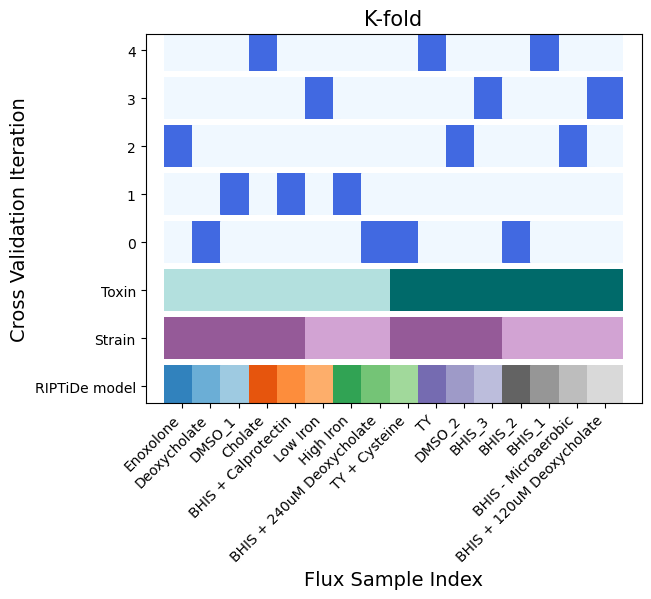

In [373]:
# Visualize K-folds using modified code from sklearn: 
#(https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

f, ax = plt.subplots(1,1)
for ii, (tr, tt) in enumerate(sgkf2.split(X, y, groups=G)):
    # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 3.5] * len(indices),
            c=indices,
            marker="_",
            lw=30,
            cmap=colors.ListedColormap(['aliceblue','royalblue']), #plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )
        
# Conditions (groups)
ax.scatter(range(len(fsdf_sorted['condition'])), [0.5]*len(fsdf_sorted['condition']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['condition'].map(group_map))

# Strains (another class)

ax.scatter(range(len(fsdf_sorted['strain'])), [1.5]*len(fsdf_sorted['strain']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['strain'].map(strain_map))

# Toxins (classes)
ax.scatter(range(len(fsdf_sorted['toxin2'])), [2.5]*len(fsdf_sorted['toxin2']), 
           marker="_", 
           lw=30, 
           c=fsdf_sorted['toxin2'].map(class_map))

yticklabels = [ "RIPTiDe model", 'Strain', "Toxin"] + list(range(5));
ax.set(yticks=np.arange(8) + 0.5,
      yticklabels=yticklabels,
      xticks=np.arange(50, 1600, step=100),
      );
ax.set_xticklabels(list(fsdf_sorted['condition'].unique()), rotation = 45, ha="right");
ax.set_xlabel('Flux Sample Index', fontsize=14)
ax.set_ylabel('Cross Validation Iteration', fontsize=14)
ax.set_title('K-fold', fontsize=15);

#plt.savefig('../figures/KfoldSplits_sgkf2.jpeg',bbox_inches='tight', dpi = 600)

#### Accuracy

In [390]:
# Create a classifier model
model=RandomForestClassifier(n_estimators=500, random_state=23)

In [391]:
# Run cross validation
cvs2 = cross_val_score(model, X, y, groups=G, scoring="accuracy", cv=sgkf2)

In [392]:
cvs2.mean()

0.9455

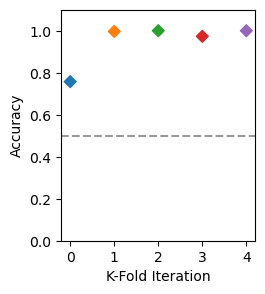

In [393]:
f, ax = plt.subplots(figsize=(2.5,3))
ax.scatter(list(range(5)), cvs2, marker='D', c=['tab:blue','tab:orange','tab:green','tab:red','tab:purple'])
ax.set(xticks=np.arange(5),
      ylim=[0,1.1])
ax.set_ylabel('Accuracy')
ax.set_xlabel('K-Fold Iteration');
ax.axhline(y = 0.5, color = 'black', linestyle = 'dashed', alpha=0.4, zorder=0)

#plt.savefig('../figures/accuracy_sgkf2.jpeg',bbox_inches='tight', dpi = 600)

#### ROC-AUC curves

/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:990: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


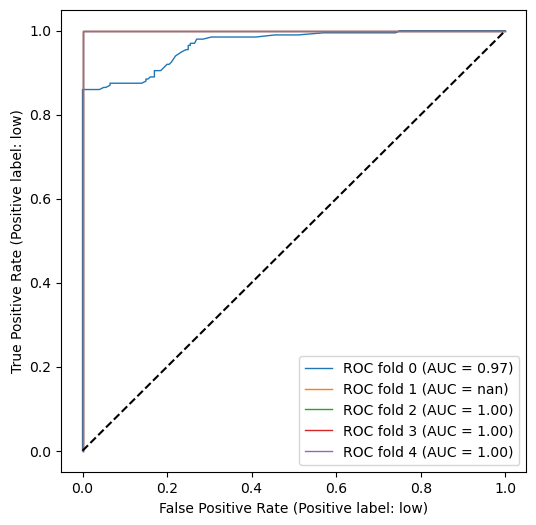

In [394]:
fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(sgkf2.split(X, y, groups=G)):
    model.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        #alpha=0.5,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

#plt.savefig('../figures/rocAUC_sgkf2.jpeg',bbox_inches='tight', dpi = 600)

#### Model predictions

In [380]:
# Split data into train (75%) and test (25%) sets (takes the final k-fold for model predictions)
for train, test in StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=25).split(X,y,groups=G):
    X_train = X.iloc[train]
    X_test = X.iloc[test]
    y_train = y.iloc[train]
    y_test = y.iloc[test]

In [381]:
# Train model
model.fit(X_train, y_train)

# Predictions
yPred = model.predict(X_test)

In [382]:
# Metrics
print("Accuracy:",metrics.accuracy_score(y_test, yPred))
print("Classification Report:")
print(metrics.classification_report(y_test, yPred))
print("Confusion Matrix:")
conMat = metrics.confusion_matrix(y_test, yPred)
print(conMat)

Accuracy: 0.97
Classification Report:
              precision    recall  f1-score   support

        high       1.00      0.94      0.97       200
         low       0.94      1.00      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

Confusion Matrix:
[[188  12]
 [  0 200]]


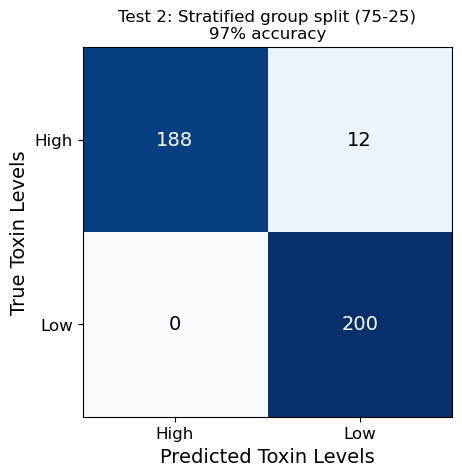

In [384]:
f,ax = plt.subplots(1,1)
ax.imshow(conMat, cmap='Blues')
ax.set_xticks([0,1])
ax.set_xticklabels(['High','Low'], fontsize = 12)
ax.set_xlabel('Predicted Toxin Levels', fontsize=14)
ax.set_yticks([0,1])
ax.set_yticklabels(['High','Low'], fontsize = 12)
ax.set_ylabel('True Toxin Levels', fontsize=14)
for i in range(conMat.shape[0]):
    for j in range(conMat.shape[1]):
        if i == j: c = 'white'
        else: c = 'black'
        ax.text(j, i, "{:.0f}".format(conMat[i,j]), size = 14, ha="center", va="center", color = c)
ax.set_title("Test 2: Stratified group split (75-25)\n97% accuracy");

#plt.savefig('../figures/rfConfusionMatrix_sgkf2.jpeg',bbox_inches='tight', dpi = 600)

# TO DO:
## fix so annotations are white on dark colors (https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

In [385]:
# Feature importance:
feature_imp2 = pd.Series(model.feature_importances_,index=X.columns.to_list()).sort_values(ascending=False)
# Select top 20 features
top20_2 = feature_imp2.head(20).sort_values(ascending=True)

In [386]:
# Add reaction names
top20_2 = pd.DataFrame(top20_2)
for i in top20_2.index:
    try:
        top20_2.loc[i, 'name'] = r20291.reactions.get_by_id(i).name
    except KeyError:
        top20_2.loc[i, 'name'] = cd630.reactions.get_by_id(i).name

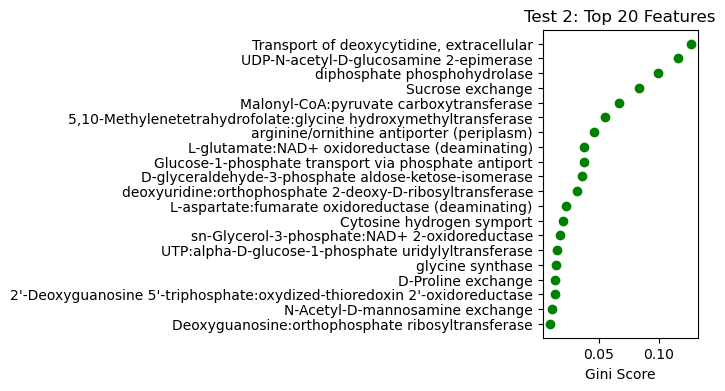

In [389]:
f, ax = plt.subplots(figsize=(2,4))
ax.scatter(top20_2[0], top20_2['name'], c='green')
ax.set_xlabel('Gini Score')
ax.set_title('Test 2: Top 20 Features')
             
#plt.savefig('../figures/top20Predictions_sgkf2.jpeg',bbox_inches='tight', dpi = 600)

In [655]:
top20_2.index.to_list()

['rxn01446_c',
 'EX_cpd00492_e',
 'rxn05234_c',
 'EX_cpd00567_e',
 'rxn00908_c',
 'rxn00213_c',
 'rxn00611_c',
 'rxn05527_c',
 'rxn08168_c',
 'rxn01799_c',
 'rxn00747_c',
 'rxn05562_c',
 'rxn00182_c',
 'rxn10131_c',
 'rxn00692_c',
 'rxn00258_c',
 'EX_cpd00076_e',
 'rxn00001_c',
 'rxn00297_c',
 'rxn05205_c']

# Visualization
- Visualization of flux sampling results across conditions using important features from RF model

## 5. Filter fsdf using top 20 features from RF
- Use results from RF model trained on flux sampling data with feature selection filters: 
    - NZV < 0.005 
    - Absolute Pearson's correlation coefficient > 0.8

In [429]:
fsdf5 = pd.concat([fsdf1[top20_2.index.to_list()], fsdf[['strain','condition','toxin2']]], axis=1)

### CHECKPOINT

In [20]:
# Checkpoint
fsdf6 = pd.read_csv('../data/rnaseqFluxSamplingNormRF3.csv').drop(columns='Unnamed: 0')

In [23]:
fsdf6 = fsdf6.T
fsdf6.columns = fsdf6.iloc[0]

In [24]:
fsdf6 = fsdf6.sort_values(by=['toxin2','strain'], ascending=[False,True], axis=1)

In [25]:
# Drop rxns w/low variance bw conditions
fsdf6 = fsdf6.drop(['rxn00611_c','rxn05205_c'])

## 6. Flux sampling figure

### Set color maps

In [617]:
# Column map (strain)
colDict={
    'CD630':'#d2a3d3',
    'CDR20291':'#955a98'
        }

colNwk = fsdf6.loc['strain']
colMap = pd.Series(colNwk).map(colDict)

In [618]:
# Column map (binary toxin labels)
colDict4={
    'low':'#b3e0de', #c1fefe',
    'high':'#006a6a'
        }
colNwk4 = fsdf6.loc['toxin2']
colMap4 = pd.Series(colNwk4).map(colDict4)

In [619]:
fsdf6.head()

,1,12,13,2,7,8,10,11,0,3,4,5,6,9,14,15
condition,BHIS + 240uM Deoxycholate,High Iron,Low Iron,BHIS + Calprotectin,Cholate,DMSO_1,Deoxycholate,Enoxolone,BHIS + 120uM Deoxycholate,BHIS - Microaerobic,BHIS_1,BHIS_2,BHIS_3,DMSO_2,TY,TY + Cysteine
strain,CD630,CD630,CD630,CDR20291,CDR20291,CDR20291,CDR20291,CDR20291,CD630,CD630,CD630,CD630,CDR20291,CDR20291,CDR20291,CDR20291
toxin2,low,low,low,low,low,low,low,low,high,high,high,high,high,high,high,high
rxn01446_c,0.648615,0.128403,0.199008,0.976269,0.0,0.918912,0.35977,0.983306,0.484852,0.455751,0.0,0.0,0.767132,0.994278,-0.001662,0.293828
EX_cpd00492_e,-0.346985,-0.18428,-0.235723,0.0,-0.182699,0.0,-0.229083,0.0,-0.396506,-0.000939,-0.000945,-0.206694,0.0,0.0,-0.133904,-0.048


/Users/dap5mb/opt/anaconda3/lib/python3.8/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


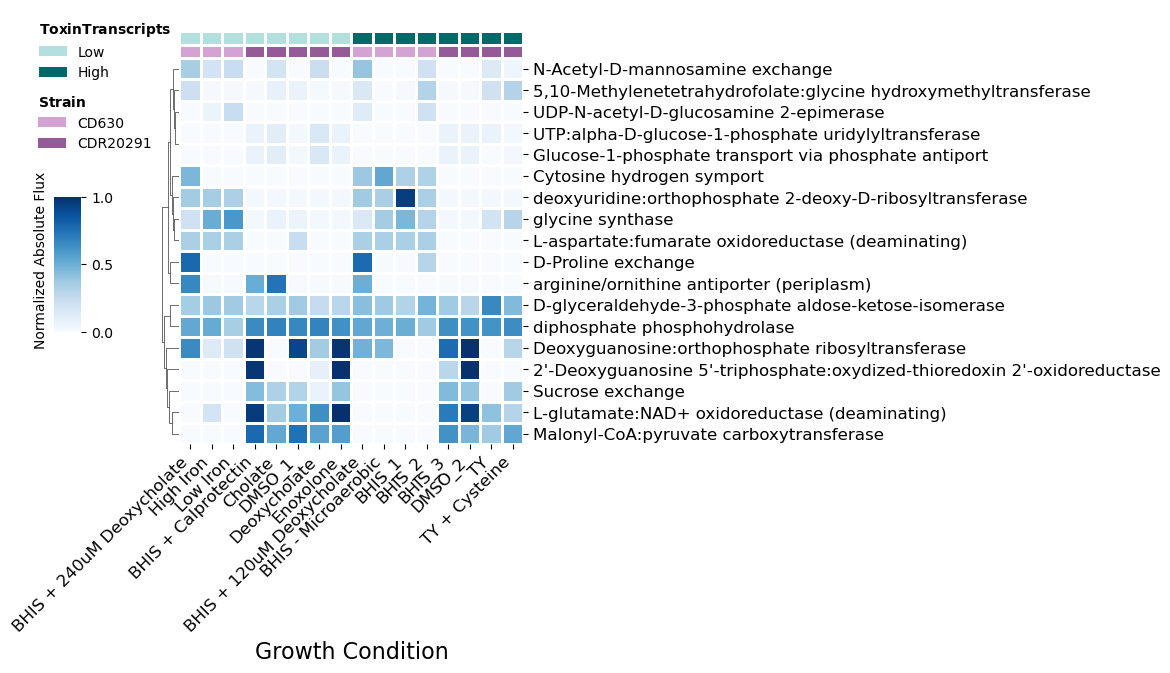

In [642]:
ax = sns.clustermap(np.abs(fsdf6.iloc[3:,:].astype(float)),
                    yticklabels = top20_2['name'].drop(['rxn00611_c','rxn05205_c']), #Drop rxns removed for low variance across conditions
                    xticklabels = fsdf6.loc['condition'],
                    cmap='Blues', 
                    dendrogram_ratio=0.05,
                    square=True,
                    figsize=(9.25,6.75),
                    col_cluster = False,
                    col_colors=[colMap4, colMap], #colMap.reindex(colMap3.index)],
                    linewidths=2, linecolor='white',
                    cbar_kws={"ticks":[-1,-0.4,0,0.5,1]},
                    cbar_pos=(-0.1, 0.5, 0.03, 0.2) ## (left, bottom, width, height)
                   )

# Toxin Legend
for label in colDict3:
    ax.ax_col_dendrogram.bar(0,0, color = colDict3[label], label = label, linewidth=0)
ax.ax_col_dendrogram.legend(loc = [-.425,-2.5], title='$\\bf{Toxin Transcripts}$',frameon=False)._legend_box.align = "left"

# Strain Legend
# create a list for the bar plot patches
strainList = []
for label in colDict:
    x = ax.ax_row_dendrogram.bar(0, 0, color=colDict[label], label=label, linewidth=0)
    strainList.append(x)

# Add strain legend
strainLegend = plt.legend(strainList, colDict, loc=[-0.75, 1.3], title='$\\bf{Strain}$', frameon = False)._legend_box.align = 'left'


ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_ymajorticklabels(), fontsize = 12);
ax.ax_heatmap.set_xticklabels(ax.ax_heatmap.get_xmajorticklabels(), fontsize = 12, rotation = 45, ha='right');
ax.ax_heatmap.set_xlabel('Growth Condition', fontsize = 16);

plt.text(-0.7, -0.1, 'Normalized Absolute Flux', rotation=90) #(horizontal, vertical)

#plt.savefig('../figures/rnaseqRFFSsgkf2_1.jpeg',bbox_inches='tight', dpi = 600)

In [48]:
strain_legend

NameError: name 'strain_legend' is not defined

In [47]:
[cd630.reactions.get_by_id(x).name for x in set(top20_1.index).intersection(set(top20_2.index))]

NameError: name 'top20_1' is not defined

# SCRATCH WORK

In [214]:
fsdf_sorted.groupby(by=['condition', 'toxin2'])['strain'].unique()

condition                  toxin2
BHIS + 120uM Deoxycholate  high         [CD630]
BHIS + 240uM Deoxycholate  low          [CD630]
BHIS + Calprotectin        low       [CDR20291]
BHIS - Microaerobic        high         [CD630]
BHIS_1                     high         [CD630]
BHIS_2                     high         [CD630]
BHIS_3                     high      [CDR20291]
Cholate                    low       [CDR20291]
DMSO_1                     low       [CDR20291]
DMSO_2                     high      [CDR20291]
Deoxycholate               low       [CDR20291]
Enoxolone                  low       [CDR20291]
High Iron                  low          [CD630]
Low Iron                   low          [CD630]
TY                         high      [CDR20291]
TY + Cysteine              high      [CDR20291]
Name: strain, dtype: object

In [32]:
[print(x, cd630.reactions.get_by_id(x).name) for x in fsdf6.iloc[3:,].index]

rxn01446_c Deoxyguanosine:orthophosphate ribosyltransferase
EX_cpd00492_e N-Acetyl-D-mannosamine exchange
rxn05234_c 2'-Deoxyguanosine 5'-triphosphate:oxydized-thioredoxin 2'-oxidoreductase
EX_cpd00567_e D-Proline exchange
rxn00908_c glycine synthase
rxn00213_c UTP:alpha-D-glucose-1-phosphate uridylyltransferase
rxn05527_c Cytosine hydrogen symport
rxn08168_c L-aspartate:fumarate oxidoreductase (deaminating)
rxn01799_c deoxyuridine:orthophosphate 2-deoxy-D-ribosyltransferase
rxn00747_c D-glyceraldehyde-3-phosphate aldose-ketose-isomerase
rxn05562_c Glucose-1-phosphate transport via phosphate antiport
rxn00182_c L-glutamate:NAD+ oxidoreductase (deaminating)
rxn10131_c arginine/ornithine antiporter (periplasm)
rxn00692_c 5,10-Methylenetetrahydrofolate:glycine hydroxymethyltransferase
rxn00258_c Malonyl-CoA:pyruvate carboxytransferase
EX_cpd00076_e Sucrose exchange
rxn00001_c diphosphate phosphohydrolase
rxn00297_c UDP-N-acetyl-D-glucosamine 2-epimerase


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [46]:
r20291.reactions.get_by_id(fsdf6.index[12])

Reaction identifier,rxn00747_c
Name,D-glyceraldehyde-3-phosphate aldose-ketose-isomerase
Memory address,0x07fe08dfa0df0
Stoichiometry,cpd00102_c <=> cpd00095_c Glyceraldehyde3-phosphate <=> Glycerone-phosphate
GPR,645463.3.peg.3217
Lower bound,-1000.0
Upper bound,1000.0
